**PREPARE NEW CHROME WINDOW**

BIG CROWD -- 200 CAMERA

**SLIDE PROGRAM**

OVERVIEW of what's POSSIBLE, not DEEP EXPLAINATION

HAND UP : DOWN for NIX HASKELL JUPYTER

HAND UP : DOWN for VEGETARIAN SWISS -- get DATA: ASK, not GOOD but SOME

Lot to LEARN NIX, HASKELL, JUPYTER, but WORTH IT

Learning GUITAR and ROCKBAND, but THIS HOW YOU GET THE GIRLS

**SLIDE BUT WHY THOUGH**

LONDON, BACK, LOTS OF HASKELL

**SLIDE JUPYTER WITH NIX**

**SLIDE JUPYTER**

EXPLAIN KERNELS

LOTS OF DEPS: PYTHON PACKAGES; GHC; IHASKELL

SHELL ; PYTHON, GHC, STACK, CABAL

**SLIDE NIX**

REPL session

PURE; FUNCTION INPUT CAPTURED

DO NOT cd /tmp; GIT CLONE; BEER ON ME

PLAY IN PYTHON; THEN HASKELL

toggle HEADER, TOOLBAR, LINE NUMBERS

**SLIDE API DISCOVERY**

CHIT CHAT ABOUT HOW TO GET DATA

**SLIDE GITHUB**

CLICK; POSTGRES; CONTRIBUTORS; TOP

**SLIDE GEONAMES**

NO IDEA WHO BEHIND IT
WORKS RELIABLY (ENOUGH)

CLICK; MINNESOTA

**SLIDE DATA PIPELINE**


EXPLAIN

**SLIDE VOCABULARY

**SLIDE APIs PROPER**

EXPLAIN NEXT STEPS

**SLIDE API REPOSITORIES**

SIDE SHELL; PS1; CURL; jq '.' -C | less -R

In [1]:
{-# LANGUAGE OverloadedStrings #-}

import Network.Wreq
import Data.Aeson.Lens
import Control.Lens

In [2]:
-- WRITE what's below (SIDE SHELL FIRST)

r <- get "https://api.github.com/search/repositories?q=language:haskell&sort=stars" -- COPY from slide

-- WRITE print5

print5 = mapM_ print . take 5

:t print5

print5 $ r ^.. responseBody . key "items" . values . key "full_name" . _String

print5 :: forall a. Show a => [a] -> IO ()

"jgm/pandoc"
"begriffs/postgrest"
"koalaman/shellcheck"
"purescript/purescript"
"elm-lang/elm-compiler"

LOTS COMPILER -- FASTER THAN GHC
postgrest -- HASKELL MAGNET

In [3]:
-- SLIDE contributors
-- WRITE 

r <- get "https://api.github.com/repos/jgm/pandoc/contributors" -- COPY from slide
print5 $ r ^.. responseBody . values .  key "login" . _String

"jgm"
"jkr"
"tarleb"
"labdsf"
"mpickering"

In [4]:
-- SLIDE users/jgm
-- WRITE

r <- get "https://api.github.com/users/jgm" -- COPY from slide
r ^. responseBody . key "location" . _String

"Berkeley, CA"

In [5]:
import qualified Data.Text.IO as T

geonamesUsername <- T.readFile ".geonames-username"

In [6]:
-- SLIDE searchJSON
-- WRITE
r <- getWith
    (defaults & param "username" .~ [geonamesUsername] & param "q" .~ ["Berkeley, CA"])
    "http://api.geonames.org/searchJSON"
r ^. responseBody . key "geonames" . nth 0 . key "countryCode" . _String

"US"

In [7]:
-- SLIDE countryInfoJSON
-- WRITE

r <- getWith (defaults & param "username" .~ [geonamesUsername] & param "country" .~ ["US"]) 
    "http://api.geonames.org/countryInfoJSON"
r ^. responseBody . key "geonames" . nth 0 . key "countryName" . _String
r ^. responseBody . key "geonames" . nth 0 . key "population" . _String

"United States"

"310232863"

SLIDE HASKELL WRAPPING

PROPER TYPES, not ANIMALS

In [8]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}

import Data.String (IsString)
import qualified Data.Text as T

newtype GithubRepo = GithubRepo { unGithubRepo :: T.Text } deriving (IsString, Show)
newtype GithubUser = GithubUser { unGithubUser :: T.Text } deriving (IsString, Show)
newtype CountryCode = CountryCode { unCountryCode :: T.Text } deriving (IsString, Show)
newtype CountryName = CountryName { unCountryName :: T.Text } deriving (IsString, Show)
newtype CountryPopulation = CountryPopulation { unCountryPopulation :: Int } 
    deriving (Num, Enum, Eq, Ord, Real, Integral, Show)

data Country = Country 
    { countryName :: CountryName
    , countryPopulation :: CountryPopulation
    } deriving Show

In [9]:
import Data.Semigroup

githubAPI :: String
geonamesAPI :: String

githubAPI = "https://api.github.com"
geonamesAPI = "http://api.geonames.org"

githubAPISearchRepos :: String
githubAPIRepos :: GithubRepo -> String
githubAPIUsers :: GithubUser -> String
githubAPIRepoContributors :: GithubRepo -> String
geonamesAPISearch :: String
geonamesAPICountryInfo :: String

githubAPISearchRepos = githubAPI <> "/search/repositories"
githubAPIRepos (GithubRepo repo) = githubAPI <> "/repos/" <> T.unpack repo
githubAPIUsers (GithubUser user) = githubAPI <> "/users/" <> T.unpack user
githubAPIRepoContributors repo = githubAPIRepos repo <> "/contributors"
geonamesAPISearch = geonamesAPI <> "/searchJSON"
geonamesAPICountryInfo = geonamesAPI <> "/countryInfoJSON"

In [10]:
import Control.Monad

geonamesError r = r ^? responseBody . key "status" . to show

-- MAYBE: airfestou "where do you want me to be"
findCountryCode :: T.Text -> IO (Maybe CountryCode)
findCountryCode location = do
    r <- getWith opts geonamesAPISearch
    forM_ (geonamesError r) $ \e ->
        fail ("At " <> T.unpack location <> ": " <> e)
    pure $ CountryCode <$> 
        r ^? responseBody 
            . key "geonames" 
            . nth 0
            . key "countryCode"
            . _String
  where
    opts = 
        defaults 
            & param "q" .~ [location] 
            & param "username" .~ [geonamesUsername]

In [11]:
-- WRITE
findCountryCode "massachusetts"

Just (CountryCode {unCountryCode = "US"})

In [12]:
:i Country -- WRITE 

In [13]:
countryByCountryCode :: CountryCode -> IO (Maybe Country)
countryByCountryCode (CountryCode code) = do
    r <- getWith opts geonamesAPICountryInfo
    forM_ (geonamesError r) $ \e -> 
        fail ("At " <> T.unpack code <> ": " <> e)
    pure $ Country 
        <$> (fmap CountryName $ r
                ^? responseBody 
                . key "geonames" 
                . nth 0 
                . key "countryName" 
                . _String) 
        <*> (fmap CountryPopulation $ r 
                ^? responseBody
                . key "geonames"
                . nth 0
                . key "population"
                . _String
                . to (read . T.unpack))     
  where
    opts = 
      defaults
          & param "country" .~ [ code ]
          & param "username" .~ [ geonamesUsername ]

In [14]:
-- WRITE
countryByCountryCode "CH"

Just (Country {countryName = CountryName {unCountryName = "Switzerland"}, countryPopulation = CountryPopulation {unCountryPopulation = 7581000}})

In [15]:
import qualified Data.ByteString as BS

githubAuth <- oauth2Token <$> BS.readFile ".github-api-token"

In [16]:
import Control.Monad.Trans.Maybe

githubUserCountry :: GithubUser -> IO (Maybe Country)
githubUserCountry user = runMaybeT $ do
    location <- MaybeT $ getLocation <$> fetchUser
    code <- MaybeT $ findCountryCode location
    MaybeT $ countryByCountryCode code
  where
    fetchUser = getWith opts $ githubAPIUsers user
    getLocation r = r ^? responseBody . key "location" . _String
    opts = defaults & auth ?~ githubAuth

In [17]:
-- WRITE "meiersi"
-- WRITE "qnikst" ANY RANDOM CHARS
-- WRITE "aherrmann" explain MAYBE -- NOTHING FOR FLY OUT

githubUserCountry "aherrmann"

Nothing

In [18]:
-- SLIDE CONDUIT (NO SHORTCUT!!!)

{-# LANGUAGE RankNTypes #-}

import Data.Conduit
import Data.Function (fix)
import Data.ByteString.Lens
import qualified Data.ByteString.Lazy as BL

import Control.Monad.IO.Class (liftIO)
import qualified Data.Conduit.Combinators as C

getAllWith :: Options -> String -> Producer IO (Response BL.ByteString)
getAllWith opts = fix $ \loop url -> do
      r <- liftIO (getWith opts url)
      yield r
      mapM_ loop $ r ^? responseLink "rel" "next" . linkURL . unpackedChars
        
topRepos :: T.Text -> Producer IO GithubRepo   
topRepos language = 
    getAllWith opts githubAPISearchRepos
    .| awaitForever (C.yieldMany . fmap GithubRepo . getFullName)
  where
    getFullName r = 
      r ^.. responseBody . key "items" . values . key "full_name" . _String
    opts = defaults 
        & param "q" .~ ["language:" <> language]
        & param "sort" .~ ["stars"]
        & param "per_page" .~ ["100"]
        & auth ?~ githubAuth

In [19]:
print5C = C.take 5 .| C.mapM_ print

-- WRITE
topRepos "haskell" $$ print5C

GithubRepo {unGithubRepo = "jgm/pandoc"}
GithubRepo {unGithubRepo = "begriffs/postgrest"}
GithubRepo {unGithubRepo = "koalaman/shellcheck"}
GithubRepo {unGithubRepo = "purescript/purescript"}
GithubRepo {unGithubRepo = "elm-lang/elm-compiler"}

In [20]:
repoContributors :: GithubRepo -> Producer IO GithubUser
repoContributors repo = 
    getAllWith opts (githubAPIRepoContributors repo)
    .| awaitForever (C.yieldMany . fmap GithubUser . getLogin)
  where
    getLogin r = r ^.. responseBody .values.key "login" . _String
    opts = defaults 
        & param "per_page" .~ ["100"]
        & auth ?~ githubAuth

In [21]:
-- COPY from above
-- topRepos -> repoContributors
repoContributors "jgm/pandoc" $$ print5C

GithubUser {unGithubUser = "jgm"}
GithubUser {unGithubUser = "jkr"}
GithubUser {unGithubUser = "tarleb"}
GithubUser {unGithubUser = "labdsf"}
GithubUser {unGithubUser = "mpickering"}

In [22]:
-- COPY from "topRepos"
-- ADD awaitForever repoContributors
topRepos "haskell" $$ awaitForever repoContributors .| print5C

GithubUser {unGithubUser = "jgm"}
GithubUser {unGithubUser = "jkr"}
GithubUser {unGithubUser = "tarleb"}
GithubUser {unGithubUser = "labdsf"}
GithubUser {unGithubUser = "mpickering"}

In [23]:
{-# LANGUAGE LambdaCase #-}

import qualified Data.HashSet as Set
import Data.Hashable (Hashable(..))

accumulateUniques :: (Eq a, Hashable a) => Int -> Sink a IO (Set.HashSet a)
accumulateUniques n = go mempty
    where
      go acc = await >>= \case
          Just x | Set.size acc < n -> go (Set.insert x acc)
          _ -> pure acc    

In [24]:
-- WRITE
C.yieldMany ["foo", "bar", "bar", "baz", undefined] $$ accumulateUniques 3

fromList ["baz","foo","bar"]

In [25]:
{-# LANGUAGE StandaloneDeriving #-}

deriving instance Eq GithubUser
deriving instance Hashable GithubUser

In [29]:

-- WRITE
users <- topRepos "haskell" 
    $$ awaitForever repoContributors
    .| accumulateUniques 100
    
print5 $ Set.toList users

GithubUser {unGithubUser = "hubertp"}
GithubUser {unGithubUser = "hftf"}
GithubUser {unGithubUser = "AlexanderS"}
GithubUser {unGithubUser = "herwigstuetz"}
GithubUser {unGithubUser = "juhp"}

In [27]:
{-# LANGUAGE DeriveGeneric #-}
{-# LANGUAGE ViewPatterns #-}

import qualified Data.Aeson as Aeson
import GHC.Generics (Generic)
import qualified Data.Binary as B
import qualified Database.LevelDB as DB
import Data.Default
import Control.Monad.Trans.Resource

deriving instance Generic GithubUser
deriving instance Generic Country
deriving instance Generic CountryName
deriving instance Generic CountryPopulation

instance B.Binary GithubUser
instance B.Binary CountryName
instance B.Binary CountryPopulation
instance B.Binary Country

cached :: (B.Binary a, B.Binary b) => (a -> IO b) -> ((a -> ResourceT IO b) -> ResourceT IO c) -> IO c
cached fetch act = runResourceT $ do
    db <- DB.open ".cache" def {DB.createIfMissing = True}
    act $ \key'@(BL.toStrict . B.encode -> key) -> do
        (fmap $ B.decode . BL.fromStrict) <$> DB.get db def key >>= \case
            Just x -> pure x
            Nothing -> do
                x <- liftIO $ fetch key'
                DB.put db def key (BL.toStrict $ B.encode x)
                pure x

In [28]:
import qualified Data.HashMap.Strict as Map
import Control.Monad

deriving instance Eq CountryPopulation
deriving instance Eq CountryName
deriving instance Eq Country
instance Hashable Country where hashWithSalt s = hashWithSalt s . unCountryName . countryName
            
userCountries :: Set.HashSet GithubUser -> IO (Map.HashMap Country Int)
userCountries cs = cached githubUserCountry $ \githubUserCountry' ->
  foldM 
    (\m u -> githubUserCountry' u >>= \case
        Nothing -> pure m
        Just c -> pure $ Map.insertWith (+) c 1 m    
    ) Map.empty (Set.toList cs)

In [30]:
-- WRITE

countries <- userCountries users -- WRITE

print5 $ Map.toList countries

(Country {countryName = CountryName {unCountryName = "Australia"}, countryPopulation = CountryPopulation {unCountryPopulation = 21515754}},3)
(Country {countryName = CountryName {unCountryName = "United Kingdom"}, countryPopulation = CountryPopulation {unCountryPopulation = 62348447}},4)
(Country {countryName = CountryName {unCountryName = "Denmark"}, countryPopulation = CountryPopulation {unCountryPopulation = 5484000}},1)
(Country {countryName = CountryName {unCountryName = "France"}, countryPopulation = CountryPopulation {unCountryPopulation = 64768389}},2)
(Country {countryName = CountryName {unCountryName = "China"}, countryPopulation = CountryPopulation {unCountryPopulation = 1330044000}},1)

In [31]:
-- SLIDE VISUALIZATIONS (NO FURTHER!!!)

import Graphics.Rendering.Chart 
import Graphics.Rendering.Chart.Backend.Cairo
import Data.Default.Class
import Control.Lens

chart :: String -> [(Country, Double)] -> Renderable ()
chart title cs = toRenderable layout 
  where
    layout = pie_title .~ title
           $ pie_plot . pie_data .~ map pitem values
           $ def
    values = take 10
           . (ix 0. _3 .~ 20) 
           . fmap (\(c, val) -> (T.unpack $ unCountryName $ countryName c, val, 0))
            $ cs
    pitem (s,v,o) = pitem_value .~ v
                  $ pitem_label .~ s
                  $ pitem_offset .~ o
                  $ def

In [32]:
import Data.Bifunctor
import Data.List

Users: 100

Countries: 22

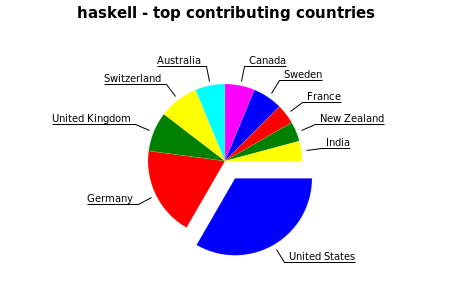

In [33]:
let lang = "haskell"
    title = "top contributing countries"

users <- topRepos lang $$ awaitForever repoContributors .| accumulateUniques 100
    
countries <- userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
    . fmap (second fromIntegral)
    $ Map.toList countries

**LOOK AT COUNTRIES**
**STICKING IT TO THE FRENCH**

Users: 100

Countries: 22

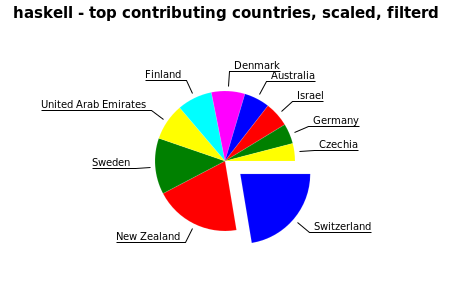

In [41]:
-- COPY FROM ABOVE

let lang = "haskell"
    title = "top contributing countries, scaled, filterd"

users <- topRepos lang $$ awaitForever repoContributors .| accumulateUniques 100
    
countries <- userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
-- WRITE FILTERS
    . fmap (\(c, n) -> (c, n / fromIntegral (countryPopulation c)))
    . filter ((> 1000000) . countryPopulation . fst)
    . fmap (second fromIntegral)
    $ Map.toList countries

In [37]:
-- WRITE
-- jaspervdj
-- mb21
-- nmattia
Set.member "mb21" users

-- SLIDE LOVE HASKELL
-- GITHUB, PANDOC, CONTIRBUTORS
-- SLIDE LOVE

True

Line 3: Functor law
Found:
fmap (\ (c, n) -> (c, n / fromIntegral (countryPopulation c))) .
  fmap (second fromIntegral) .
    filter ((> 1000000) . countryPopulation . fst)
Why not:
fmap
  ((\ (c, n) -> (c, n / fromIntegral (countryPopulation c))) .
     second fromIntegral)
  . filter ((> 1000000) . countryPopulation . fst)

Users: 3000

Countries: 74

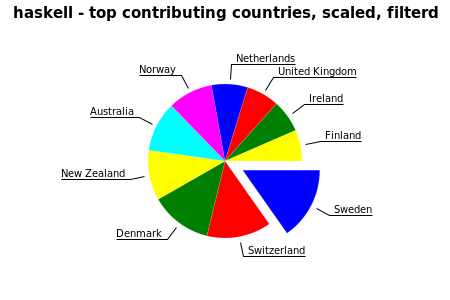

In [40]:
-- COPY FROM ABOVE, BUMP accumulateUniques

let lang = "haskell"
    title = "top contributing countries, scaled, filterd"

users <- topRepos lang $$ awaitForever repoContributors .| accumulateUniques 3000
    
countries <- userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
    . fmap (\(c, n) -> (c, n / fromIntegral (countryPopulation c)))
    . fmap (second fromIntegral)
    . filter ((> 1000000) . countryPopulation . fst)
    $ Map.toList countries

In [ ]:
Map.filterWithKey (\c _ -> countryName c == "India") countries -- WRITE